In [21]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from keras.optimizers import Adam

In [2]:
BATCH_SIZE=32
IMAGE_SIZE=256
CHANNELS=3
EPOCHS=50

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "plant",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 4 classes.


In [4]:
class_names=dataset.class_names

In [5]:
class_names

['Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'The model is only able to process potatos leaves']

(32, 256, 256, 3)
[0 1 1 0 0 1 1 1 1 0 2 0 1 0 1 0 0 1 1 0 1 1 1 1 1 0 1 2 1 1 1 1]


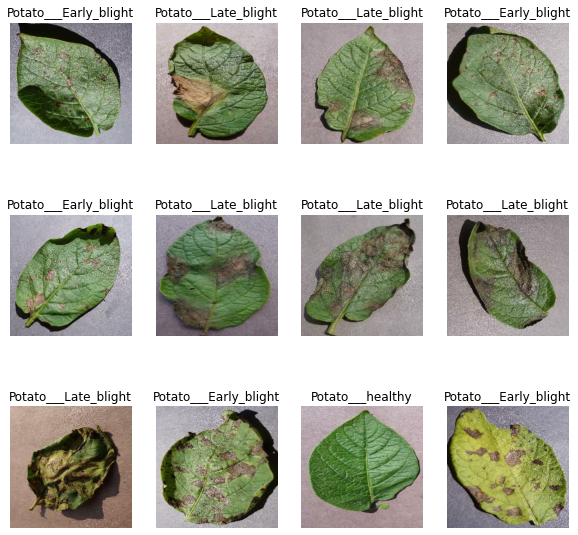

In [6]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    
    for i in range(12):
        ax=plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[labels_batch[i]])
        plt.axis('off')
  

In [7]:
def get_partition_dataset(ds, training_split=0.8, test_split=0.1, val_split=0.1, shuffle=True, shuffle_size=10000):
    assert(training_split+test_split+val_split)==1
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
        
        
    train_size=int(ds_size*training_split)
   
    val_size=int(ds_size*val_split)
    
    training_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return training_ds, val_ds, test_ds;
    

In [8]:
training_ds, val_ds, test_ds=get_partition_dataset(dataset)


In [9]:
len(training_ds)


54

In [10]:
len(test_ds)

8

In [11]:
taining_ds=training_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].numpy()/255)

[[[0.67058825 0.6313726  0.627451  ]
  [0.68235296 0.6431373  0.6392157 ]
  [0.6784314  0.6392157  0.63529414]
  ...
  [0.54901963 0.52156866 0.54901963]
  [0.5529412  0.5254902  0.5529412 ]
  [0.54901963 0.52156866 0.54901963]]

 [[0.65882355 0.61960787 0.6156863 ]
  [0.67058825 0.6313726  0.627451  ]
  [0.67058825 0.6313726  0.627451  ]
  ...
  [0.54901963 0.52156866 0.54901963]
  [0.54509807 0.5176471  0.54509807]
  [0.5372549  0.50980395 0.5372549 ]]

 [[0.6666667  0.627451   0.62352943]
  [0.67058825 0.6313726  0.627451  ]
  [0.67058825 0.6313726  0.627451  ]
  ...
  [0.54901963 0.52156866 0.54901963]
  [0.53333336 0.5058824  0.53333336]
  [0.52156866 0.49411765 0.52156866]]

 ...

 [[0.42745098 0.35686275 0.35686275]
  [0.48235294 0.4117647  0.4117647 ]
  [0.49411765 0.42352942 0.42352942]
  ...
  [0.16078432 0.15294118 0.17254902]
  [0.16862746 0.14901961 0.17254902]
  [0.15686275 0.14901961 0.16862746]]

 [[0.4        0.32941177 0.32941177]
  [0.4627451  0.39215687 0.39215687]


In [13]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [14]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [15]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=4
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
    
    
])
model.build(input_shape=input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [23]:
model.compile(
    optimizer=Adam(0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
history=model.fit(
    training_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/50
54/54 [==============================] - 278s 4s/step - loss: 1.0911 - accuracy: 0.4413 - val_loss: 0.8984 - val_accuracy: 0.4531
Epoch 2/50
54/54 [==============================] - 174s 3s/step - loss: 0.9001 - accuracy: 0.4736 - val_loss: 0.8877 - val_accuracy: 0.4948
Epoch 3/50
54/54 [==============================] - 197s 3s/step - loss: 0.8843 - accuracy: 0.5158 - val_loss: 0.8624 - val_accuracy: 0.4740
Epoch 4/50
54/54 [==============================] - 189s 3s/step - loss: 0.8559 - accuracy: 0.5799 - val_loss: 0.8104 - val_accuracy: 0.6146
Epoch 5/50
54/54 [==============================] - 190s 3s/step - loss: 0.7749 - accuracy: 0.6968 - val_loss: 0.6752 - val_accuracy: 0.7656
Epoch 6/50
54/54 [==============================] - 192s 3s/step - loss: 0.5585 - accuracy: 0.7841 - val_loss: 0.6658 - val_accuracy: 0.7031
Epoch 7/50
54/54 [==============================] - 191s 3s/step - loss: 0.4426 - accuracy: 0.8263 - val_loss: 0.5330 - val_accuracy: 0.8177
Epoch 8/50
54

In [25]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 31s 708ms/step - loss: 0.4879 - accuracy: 0.8633


In [26]:
scores

[0.4879406988620758, 0.86328125]

In [27]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [28]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

In [29]:
history.history['accuracy']

[0.44131454825401306,
 0.47359153628349304,
 0.5158450603485107,
 0.5798611044883728,
 0.6967592835426331,
 0.7841435074806213,
 0.8262910842895508,
 0.8685445785522461,
 0.8978873491287231,
 0.9330986142158508,
 0.9413145780563354,
 0.9471830725669861,
 0.9571596384048462,
 0.9512910842895508,
 0.9700704216957092,
 0.9465962648391724,
 0.9694835543632507,
 0.9559859037399292,
 0.9712441563606262,
 0.9683098793029785,
 0.9653756022453308,
 0.9712441563606262,
 0.9559859037399292,
 0.96772301197052,
 0.9759389758110046,
 0.9712441563606262,
 0.9706572890281677,
 0.9712441563606262,
 0.9782863855361938,
 0.9747652411460876,
 0.9765258431434631,
 0.9776995182037354,
 0.9730046987533569,
 0.9771126508712769,
 0.9718309640884399,
 0.9636150002479553,
 0.9826388955116272,
 0.9812206625938416,
 0.9812206625938416,
 0.9803240895271301,
 0.9806337952613831,
 0.9776995182037354,
 0.9847418069839478,
 0.9794601202011108,
 0.9788732528686523,
 0.9841549396514893,
 0.9771126508712769,
 0.9630281925

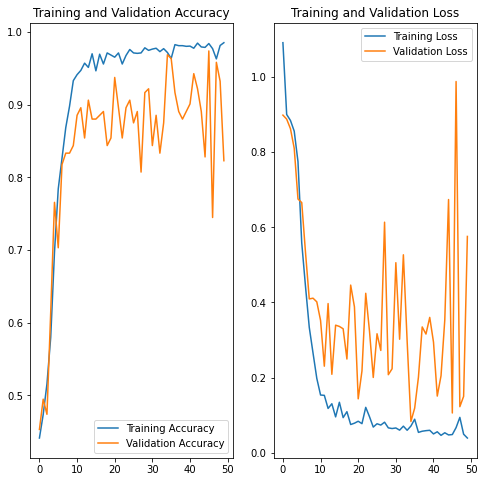

In [31]:
plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plt.plot(range(50), acc, label="Training Accuracy")
plt.plot(range(50), val_acc, label="Validation Accuracy")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(50), loss, label="Training Loss")
plt.plot(range(50), val_loss, label="Validation Loss")
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict
[[[176 174 185]
  [177 175 186]
  [177 175 186]
  ...
  [154 156 169]
  [152 154 167]
  [146 148 161]]

 [[177 175 186]
  [177 175 186]
  [176 174 185]
  ...
  [155 157 170]
  [153 155 168]
  [148 150 163]]

 [[178 176 187]
  [177 175 186]
  [175 173 184]
  ...
  [154 156 169]
  [154 156 169]
  [150 152 165]]

 ...

 [[122 119 126]
  [122 119 126]
  [135 132 139]
  ...
  [133 131 142]
  [128 126 137]
  [132 130 141]]

 [[137 134 141]
  [154 151 158]
  [137 134 141]
  ...
  [134 132 143]
  [131 129 140]
  [130 128 139]]

 [[138 135 142]
  [139 136 143]
  [155 152 159]
  ...
  [134 132 143]
  [135 133 144]
  [133 131 142]]]
Actual Label:  Potato___Early_blight
1/1 [==============================] - 2s 2s/step
Predicted Label:  Potato___Late_blight


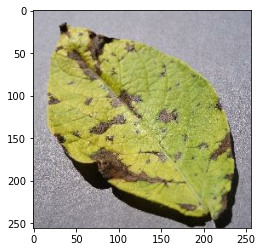

In [32]:
import numpy as np

for images_batch, labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype("uint8")
    print("First image to predict")
    print(first_image)
    plt.imshow(first_image)
    print("Actual Label: ", class_names[labels_batch[0].numpy()])
    
    batch_prediction=model.predict(image_batch)
    print("Predicted Label: ", class_names[np.argmax(batch_prediction[0])])
    

In [33]:
def predict(model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(img)
    img_array=tf.expand_dims(img_array, 0)
    
    predictions=model.predict(img_array)
    print(predictions)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100 * (np.argmax(predictions[0])), 2)
    
    return predicted_class, confidence

1/1 [==============================] - 0s 234ms/step
[[9.9999976e-01 1.9520489e-07 1.0625820e-10 1.2156289e-17]]
1/1 [==============================] - 0s 68ms/step
[[9.3240148e-01 6.7009002e-02 5.8949896e-04 9.0056886e-09]]
1/1 [==============================] - 0s 57ms/step
[[9.9999821e-01 1.6160197e-06 7.4189657e-08 3.6986766e-13]]
1/1 [==============================] - 0s 55ms/step
[[2.3553210e-05 5.1173387e-04 9.9946469e-01 1.2684143e-10]]
1/1 [==============================] - 0s 59ms/step
[[9.9767059e-01 2.3085617e-03 2.0863126e-05 3.4389866e-11]]
1/1 [==============================] - 0s 66ms/step
[[9.9999964e-01 3.7022360e-07 1.5615488e-08 5.2059363e-14]]
1/1 [==============================] - 0s 55ms/step
[[1.5022475e-07 3.4141310e-02 9.6585852e-01 1.8645220e-13]]
1/1 [==============================] - 0s 65ms/step
[[9.9999833e-01 1.6637805e-06 3.1773251e-09 3.4301622e-14]]
1/1 [==============================] - 0s 53ms/step
[[1.00000000e+00 2.66098041e-08 3.50828242e-12 1.29

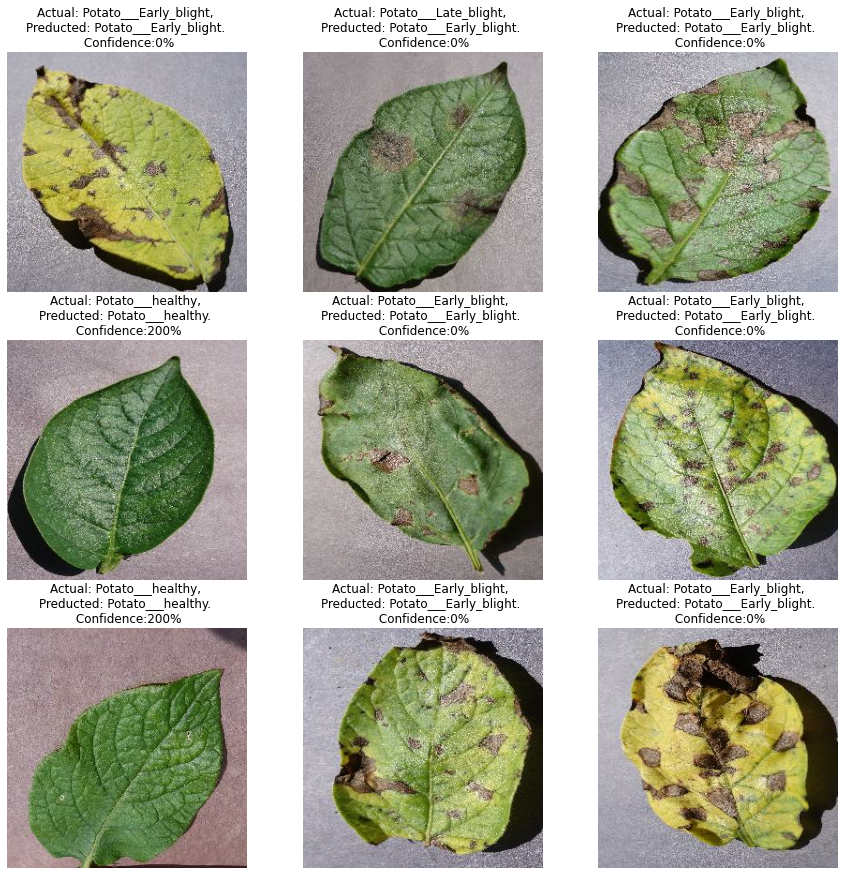

In [34]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class, confidence=predict(model, images[i].numpy())
        
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \nPreducted: {predicted_class}. \n Confidence:{confidence}%")
        plt.axis("off")
        

In [35]:
model_version=5
model.save(f"../models/{model_version}")


INFO:tensorflow:Assets written to: ../models/5\assets


INFO:tensorflow:Assets written to: ../models/5\assets
